# Set up

In [2]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm


import os
import pickle

import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


torch.set_default_dtype(torch.float32)

####################################################################

Device = 'cuda'



# MVGP Model

In [3]:
checkpoint = torch.load('multitask_gp_checkpoint_21.pth', map_location=Device)
model_params = checkpoint['model_params']


MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y_21, 
                                               num_latents=model_params['num_latents'], 
                                               num_inducing=model_params['num_inducing'], 
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y_21.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

# input point

In [4]:
row_idx = 10

input_point = test_y_21[row_idx,:]
# local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k = 100)
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y_21, k = 100)

bounds = bound.get_bounds(local_train_x)

In [ ]:
bounds.shape

[(0.3494, 4.9537),
 (0.1665, 4.9525),
 (0.154, 4.6253),
 (0.1461, 4.9832),
 (1.3135, 4.9733),
 (0.1701, 4.9659),
 (1.5515, 4.9979),
 (0.1377, 4.9867),
 (0.1272, 3.0881),
 (0.15, 4.9676)]

In [8]:
dim = len(bounds)
n_points = 5

sobol_engine = torch.quasirandom.SobolEngine(dim, scramble=True)
sobol_samples = sobol_engine.draw(n_points)


lower = torch.tensor([b[0] for b in bounds], dtype=torch.float32)
upper = torch.tensor([b[1] for b in bounds], dtype=torch.float32)
scaled_samples = lower + (upper - lower) * sobol_samples


initial_params_list = [sample.tolist() for sample in scaled_samples]

# MCMC

In [23]:

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as transforms
from pyro.infer import MCMC, HMC



def run_mcmc_Uniform_initial_params_HMC(
    Pre_function, Models, Likelihoods, row_idx, test_y, bounds,
    num_sampling=2000, warmup_step=1000, num_chains=1, device='cpu',
    initial_params=None
):
    test_y = test_y.to(dtype=torch.float32, device=device)

    bounds = [
        (
            torch.tensor(b[0], dtype=torch.float32, device=device),
            torch.tensor(b[1], dtype=torch.float32, device=device)
        ) for b in bounds
    ]

    def model():
        params = []
        for i, (min_val, max_val) in enumerate(bounds):
            param_i = pyro.sample(f'param_{i}', dist.Uniform(min_val, max_val))
            params.append(param_i)

        theta = torch.stack(params)
        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))
        y_obs = test_y[row_idx, :]
        pyro.sample('obs', gp_pred, obs=y_obs)

    nuts_kernel = HMC(model, step_size=0.1, num_steps=20)

    initial_params_dict = {
        f'param_{i}': torch.tensor(p, dtype=torch.float32, device=device)
        for i, p in enumerate(initial_params)
    }

    mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains, initial_params=initial_params_dict)
    mcmc.run()



    return mcmc

## Initial point: 

In [10]:
initial_params_list[0]

[3.4087984561920166,
 0.19102801382541656,
 0.861991286277771,
 1.1342551708221436,
 2.3137426376342773,
 1.5761973857879639,
 3.202972412109375,
 2.811861276626587,
 2.029712677001953,
 0.3489367365837097]

In [24]:
mcmc_result_1 = run_mcmc_Uniform_initial_params_HMC(
    Prediction.preds_distribution_fast_pred_var, MVGP_models, MVGP_likelihoods, 
    row_idx, test_y_21, bounds, 
    num_sampling=1500, warmup_step=0, num_chains=1, device=Device,
    initial_params = initial_params_list[0]
    )

Warmup:   0%|          | 0/1500 [00:00, ?it/s]

KeyboardInterrupt: 

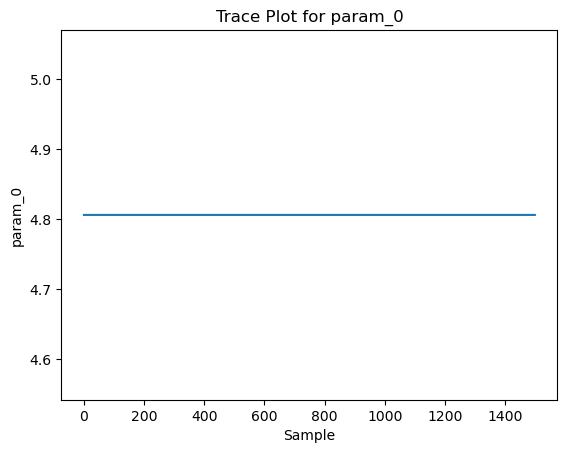

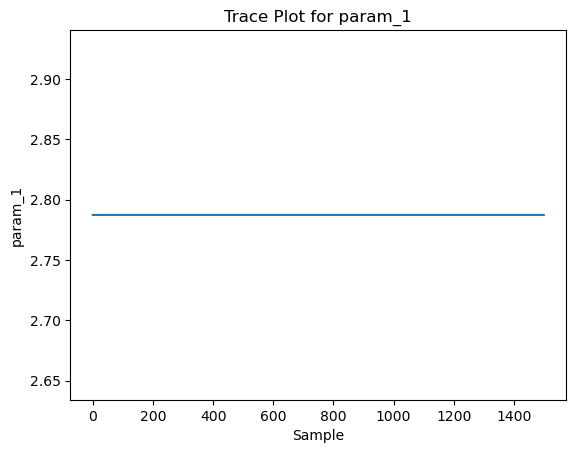

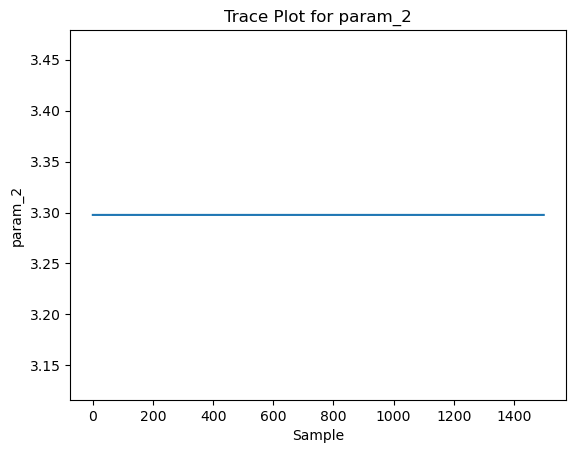

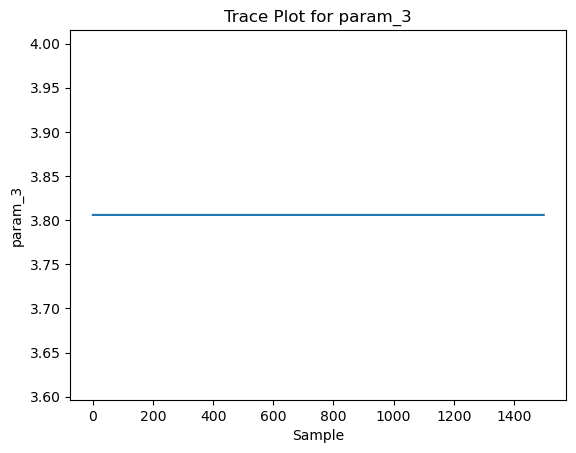

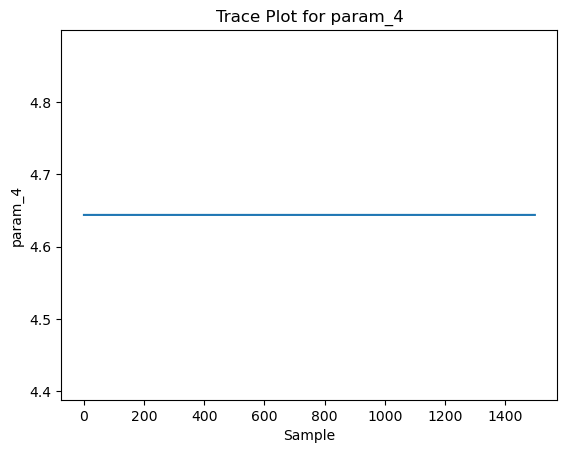

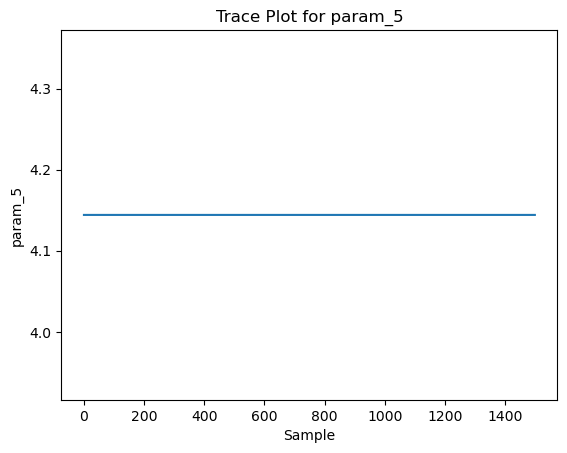

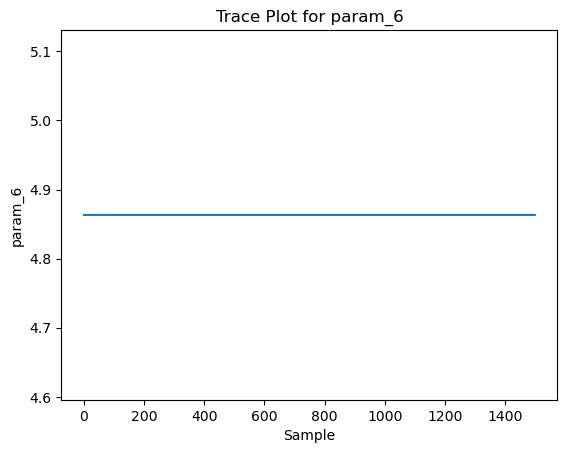

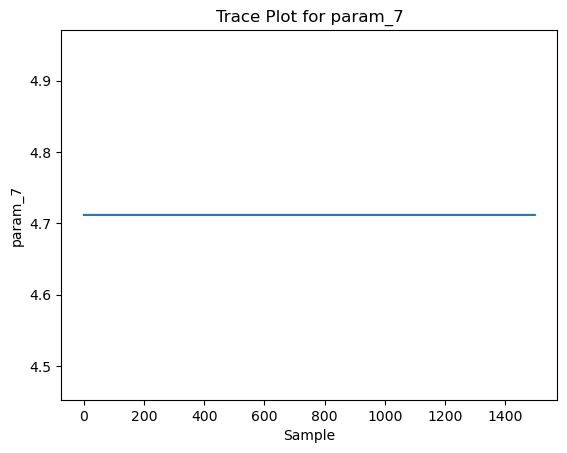

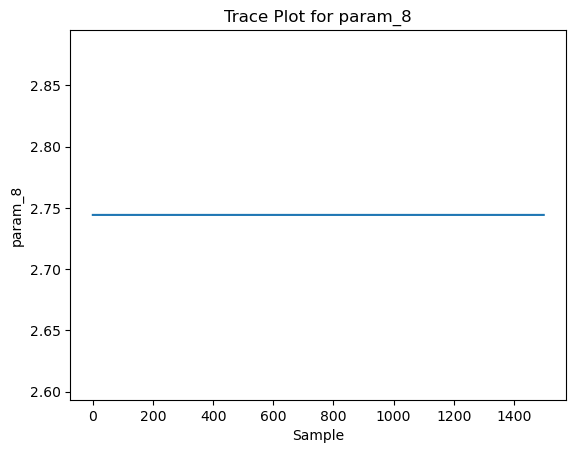

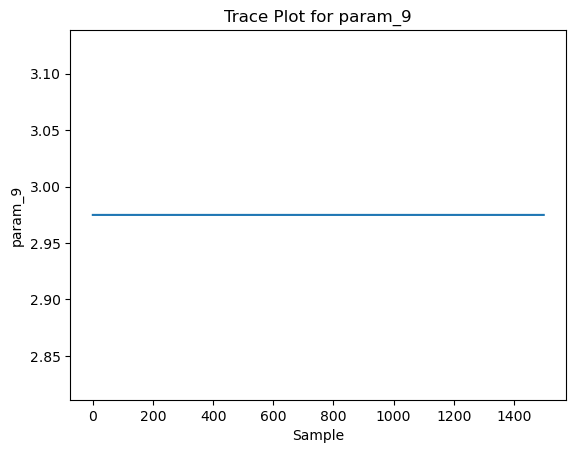

In [17]:
import matplotlib.pyplot as plt

for name, values in mcmc_result_1.get_samples().items():
    values = values.cpu().numpy()
    if values.ndim == 1:  # 单参数
        plt.figure()
        plt.plot(values)
        plt.xlabel('Sample')
        plt.ylabel(name)
        plt.title(f'Trace Plot for {name}')
    else:  # 多维参数
        for i in range(values.shape[1]):
            plt.figure()
            plt.plot(values[:, i])
            plt.xlabel('Sample')
            plt.ylabel(f'{name}[{i}]')
            plt.title(f'Trace Plot for {name}[{i}]')
plt.show()


# End